Here, we will implement some distributed optimisation algorithms.
First, we will try the DGD Algorithm for 4 nodes. They will have optimisation objectives as follows:

$f(x) = \sum_{i = 1} ^ {4} f_i(x)
x \in \mathbb{R} ^ 4$
where

$f_i(x) = (\sum_{j \neq i}{\frac{(x ^ j) ^ 2}{6}}) + \frac{(x ^ i) ^ 2}{2}$

where $x ^ i$ is the i-th component of $x$.
We note that all the functions are convex and acheive minima identically at $(0, 0, 0, 0)$. So, in theory all $x_i$ must converge to $(0, 0, 0, 0)$

We assume the graph to be fully connected(static). The weight matrix(is doubly stochastic) will be given as : 

$W = \begin{bmatrix}
1/4 & 1/4 & 1/4 & 1/4\\
    1/4 & 1/4 & 1/4 & 1/4\\
    1/4 & 1/4 & 1/4 & 1/4\\
    1/4 & 1/4 & 1/4 & 1/4\\
    \end{bmatrix}$

or 
$W = \begin{bmatrix}
1/2 & 1/2 & 0 & 0\\
    1/2 & 1/2 & 0 & 0\\
    0 & 0 & 1/2 & 1/2\\
    0 & 0 & 1/2 & 1/2\\
    \end{bmatrix}$


The simplified DGD Algorithm works as follows:

$x_i(k + 1) := \left(\sum_{j=1}^{4}w_{ij} \cdot x_j(k) \right)  − \alpha(k) \cdot d_i(k)$

where $x_i(k)$ is i-th node's estimate of the solution at the k-th iteration, the first term on RHS is the consensus term

$w_{ij}$ is the weight of edge j to i

$\alpha(k)$ is the learning rate at the k-th iteration

$\nabla f(x_i(k)) = d_i(k)$ is the subgradient for the i-th node at the k-th step at the point $x_i(k)$

We choose $\alpha(k) = 1/k$ since it is the simplest sequence satisfying the convergence requirements of the diminishing step sizes.

In our case the subgradient for node $i$ comes out to be:

$d_i ^ j(k) = \frac{1}{3} \cdot  x_i ^ j(k) \;\;\; ∀ j \neq i$

$d_i ^ i(k) = x_i ^ i$

$(W \cdot X)_{ij} = \sum_{k = 1} ^ {4} w_{ik} \cdot  x_k ^ j$

In vectorised form,  $X(k)$ denotes a matrix with i-th row row being $x_i(k)^T$ and similarly, we define $\nabla f(k)$ with i-th row being the sub-gradient at the i-th node i.e. $\nabla f_i(x_i(k))^T$. Note that both $X(k), \nabla f(k) \in \mathbb{R}^{n \times n}$, n being the number of nodes/dimension of $x_i$

So, after vectorising, we get:

$X(k+1) = W \cdot X(k) - \alpha(k) \cdot \nabla f(k)$

In [7]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set_theme(style='darkgrid')


In [151]:
def DGD(W:np.array,X:np.array,iter:np.int32,subgradient,alpha):
    '''
    # Weight Matrix 

        W: Doubly stochatic matrix
    
    # Intial solution vector

        X:initial solution , n*m nd array , n:number of agents and m:number of components in vector
        
        X[i] is the solution vector at the ith agent . It is a vector and not the ith componenet of 
        the vector.
        By definition of consensus step the X[1]==X[2]==....X[k]for all agent k . That is final solution
        must be same for all the agents.

    # alpha:
        Function which accepts one arguement i.e ith iteration and return constant
    # Note:
     
        Each agent may optimize different number of variables in it. 
        In general case there are n agents and m variables
        iter: Iterations

    '''

    if(X.ndim!=2):
        return "dimension of input vector wrong"
    values =[]
    values.append(X)
    n ,m= X.shape

    for i in range(iter):
        D = subgradient_assemble(subgradient,X)
        X = np.dot(W,X) - alpha(i) * D
        values.append(X)

    return np.array(values)

In [152]:
# Assuming f(x) = x_1^2 + x_2^2 +x_3^2 +x_4^2
# and fk(x) = x_i^2 , local minimization problem at kth agent
# grad f2(x)= (0,2x_2,0,0)

def subgradient_1(i,Xi):
    # i : the local problem
    # Xi :solution at this index
    D=np.zeros_like(Xi)
    D[i] = 2*Xi[i]
    return D

def subgradient_assemble(subgradient,X):
    D = np.zeros(X.shape)
    for i in range(X.shape[0]):
        D[i] = subgradient(i,X[i])
    return D

def alpha(i):
    return 10/(i+1)
values= DGD(W,X,100,subgradient_1,alpha)
# fig ,ax=plt.subplots()

# for i in range(0,4):
#     sbn.lineplot(x=np.arange(1,len(values)+1),y=np.ravel(values[:, i]),ax=ax,label=f'x{i+1}')

# ax.set_title(
#     ' DGD Algorithm \n min F(x) = $\sum{(x_i)^2}$ and $f_i(x) = (x_i)^2$ ')



In [153]:
def print_plot(values,title = "Values v/s Epochs for all Agents"):
    sol = np.array([1,2,3,4],dtype = float)
    print("X = \n", values[0])
    print("Output = \n",values[-1])
    print("Norms of errors = \n",[np.linalg.norm(values[-1][i] - sol) for i in range(4)])
    fig ,axes =plt.subplots(nrows=2,ncols=2,figsize=(20,10))
    fig.suptitle(title)
    for variable ,ax in zip(range(0,4),np.ravel(axes)):
        
    # variable='x1'

        for i in range(0, 4):
            sbn.lineplot(x=np.arange(1, values.shape[0]+1),
            y=np.ravel(values[:, i,variable]), ax=ax, label=f'Agent{i+1}')

        
        ax.axhline(y=variable+1,color='black',linestyle='-',label=f'Y={variable+1}')

        ax.set_ylabel(f'Variable x{variable+1}')
        ax.set_xlabel('Iterations')
        ax.legend()
    plt.show()

X = 
 [[1.80883407 0.96783587 2.66977256 2.01411264]
 [1.80883407 0.96783587 2.66977256 2.01411264]
 [1.80883407 0.96783587 2.66977256 2.01411264]
 [1.80883407 0.96783587 2.66977256 2.01411264]]
Output = 
 [[1.03703953 1.94276421 2.98168815 3.88987813]
 [1.04485165 1.95273335 2.98168815 3.88987813]
 [1.04485165 1.94276421 2.98487765 3.88987813]
 [1.04485165 1.94276421 2.98168815 3.9090588 ]]
Norms of errors = 
 [0.13080524675438393, 0.12925925838583505, 0.13282739721302356, 0.11786955583926198]


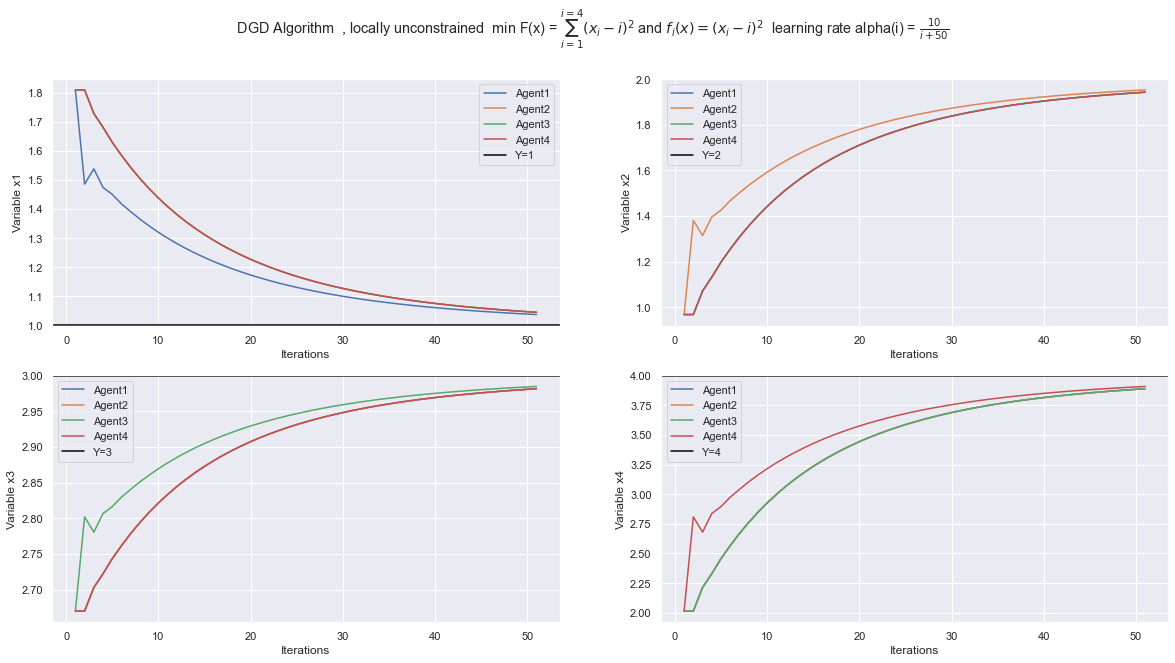

In [154]:
# min f(x) = (x1-1)^2 + (x2-2)^2 + (x3-3)^2 + (x4-4)^2
# and fi(x) = (xi-i)^2 , grad fi'(x)= (0,0,2(xi-i),0)
W = np.array([[1/4, 1/4, 1/4, 1/4], [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4], [1/4, 1/4, 1/4, 1/4]])
X= np.repeat(np.random.rand(1,4),repeats = 4, axis = 0)*4
def subgradient_2(i,Xi):
    D= np.zeros_like(Xi)
    D[i] = 2*(Xi[i]-(i+1))
    return D
def alpha(i):
    return 10/(i+50)
values_dgd= DGD(W,X,50,subgradient_2,alpha)
sol = np.array([1,2,3,4],dtype= float)

print_plot(values_dgd,' DGD Algorithm  , locally unconstrained  min F(x) = $\sum_{i=1}^{i=4}{(x_i-i)^2}$ and $f_i(x) = (x_i-i)^2$  learning rate alpha(i) = $ \\frac{10}{i+50}$ ')

Now, we try the EXTRA(Exact First Order) algorithm. This is a discrete-time algorithm with fixed step sizes. The notation largely being the same as above, $\alpha$ is now a constant and doesn't depend on the epoch.

We use a random guess as $x_i(0)$, then we calculate:
$x_i(1) = \left(\sum_{j=1}^{4}w_{ij} \cdot x_j(k) \right)  − \alpha \cdot \nabla f_i(x_i(0))$

Now, we calculate $x_i(k+2)$ iteratively using $x_j(k+1)$ and $x_j(k) \;\;\; \forall j \in [n]$ 


$x_i(k+2) := x_i(k+1) + \left( \sum_{j=1}^{n}w_{ij} \cdot x_j(k + 1) \right) \;− \left(\sum_{j=1} \tilde{w}_{ij} \cdot x_j (k)\right) − α \cdot \nabla f_i(x_i(k+1) − \nabla f_i(x_i(k)))$

where $\tilde{W}$ is weight mixing matrix which is also doubly stochastic. We assume $\tilde{W} = \frac{W+I}{2}$ as mentioned in EXTRA paper [here](http://arxiv.org/abs/1404.6264).

Here, we denote first step by
$X(1) := W \cdot X(0) - \alpha \cdot \nabla f(0)$

And after that:

$X(k+2) := (I+W) \cdot X(k+1) - \tilde{W} \cdot X(k) -\alpha \cdot \left( \nabla f(k+1) - \nabla f(k) \right) $



In [99]:
def EXTRA(W:np.array,X:np.array,iter:np.int32,subgradient,alpha):
    if(X.ndim!=2):
        return "dimension of input vector wrong"
    values =[]
    values.append(X)
    n ,m= X.shape
    X = np.dot(W,X) - alpha * subgradient_assemble(subgradient,X)
    values.append(X)
    W_tilde = (np.eye(n) + W)/2
    D1 = subgradient_assemble(subgradient,values[-2])
    for i in range(1,iter):
        D0 = D1
        D1 = subgradient_assemble(subgradient,values[-1])
        X_new = 2*np.dot(W_tilde,values[-1]) - np.dot(W_tilde,values[-2]) - alpha*(D1 - D0)
        values.append(X_new)
        X=X_new

    return np.array(values)

In [156]:
sol = np.array([1,2,3,4],dtype = float)
X = np.random.rand(4,4)*4
print(X)
for alpha in np.linspace(0.2, 0.4, 10):
    values = EXTRA(W,X,50,subgradient_2,alpha)
    print(f"alpha = {alpha}, answer = ",np.average(np.array([np.linalg.norm(values[-1][i] - sol) for i in range(4)])))
    # print([np.linalg.norm(values[-1][i] - sol) for i in range(4)])

# Hence the Hyper-parameter Tuning reveals best learning rate to be 0.32 for EXTRA

[[2.80658555 0.50402494 1.97840481 0.92838241]
 [3.49590012 2.97877401 2.65527005 3.71030433]
 [2.09945585 1.68194292 2.46828626 1.01532507]
 [1.87527891 2.84513324 3.23044883 2.30551546]]
alpha = 0.2, answer =  0.009114680720690417
alpha = 0.22222222222222224, answer =  0.003979737167479001
alpha = 0.24444444444444446, answer =  0.0015611225036413368
alpha = 0.26666666666666666, answer =  0.0005165660414444887
alpha = 0.2888888888888889, answer =  0.00012419002201892934
alpha = 0.3111111111111111, answer =  1.136212463158458e-05
alpha = 0.33333333333333337, answer =  2.507392066970683e-06
alpha = 0.35555555555555557, answer =  4.569723033656045e-06
alpha = 0.37777777777777777, answer =  5.396128674317166e-06
alpha = 0.4, answer =  6.7407456688514085e-06


X = 
 [[2.19016481 0.10441946 0.63706308 2.30954855]
 [0.49614039 1.92224964 2.34860781 1.54365337]
 [2.95159654 0.39386461 0.26171457 3.3787224 ]
 [2.58317097 3.7816469  1.7552825  0.11730858]]
Output = 
 [[1.00000146 2.00000164 3.00000435 4.00000495]
 [0.99999707 2.00000011 3.0000043  4.00000497]
 [0.999997   2.00000164 2.99999626 4.00000492]
 [0.99999701 2.00000153 3.00000431 3.99999453]]
Norms of errors = 
 [6.945313307619514e-06, 7.193771958065792e-06, 7.056869604769072e-06, 7.733107547809522e-06]


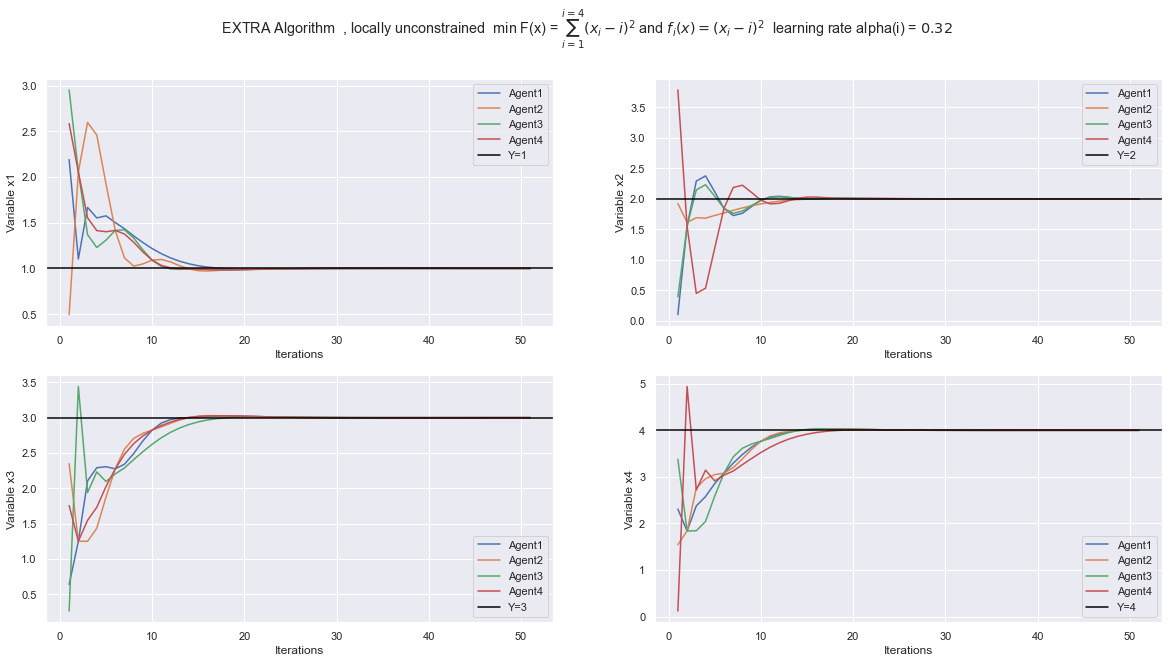

In [161]:
W = np.array([[1/4, 1/4, 1/4, 1/4], [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4], [1/4, 1/4, 1/4, 1/4]])
X= np.random.rand(4,4)*4
values_extra= EXTRA(W,X,50,subgradient_2,0.4)

print_plot(values_extra,title = ' EXTRA Algorithm  , locally unconstrained  min F(x) = $\sum_{i=1}^{i=4}{(x_i-i)^2}$ and $f_i(x) = (x_i-i)^2$  learning rate alpha(i) = $ 0.32$ ')

For DIG algorithm, we calculate another vector $y_i(k)$ at k-th step for each node $i$. This is the estimate of the average gradient at time step k.

We assume $x_i(0)$ randomly and assign $y_i(k) := \nabla f_i(x_i(0))$

We get iterative steps:

$x_i(k + 1) := \left(\sum_{j=1}^{4}w_{ij} \cdot x_j(k) \right)  − \alpha(k) \cdot y_i(k)$

$y_i(k + 1) := \left(\sum_{j=1}^{4}w_{ij} \cdot y_j(k) \right)  + \nabla f_i(x_i(k+1)) - \nabla f_i(x_i(k))$

Vectorising as before, and taking $Y(k)$ to be the matrix with i-th row as $y_i(k)^T$
We get, initially

$Y(0) = \nabla f(X(0))$

and then,

$X(k+1) = W \cdot X(k) - \alpha \cdot Y$

$Y(k+1) = W \cdot Y(k) + \nabla f(k+1) - \nabla f(k)$

In [145]:
def DIG(W:np.array,X:np.array,iter:np.int32,subgradient,alpha):
    if(X.ndim!=2):
        return "dimension of input vector wrong"
    values =[]
    D1 = Y = subgradient_assemble(subgradient, X)
    values.append(X)
    for i in range(iter):
        X_new = np.dot(W,X) - alpha * Y
        D0 = D1
        D1 = subgradient_assemble(subgradient,X_new)
        Y_new = np.dot(W,Y) + D1 - D0
        values.append(X_new)
        X=X_new
        Y=Y_new

    return np.array(values)

In [ ]:
sol = np.array([1,2,3,4],dtype = float)
X = np.random.rand(4,4)*4
print(X)
for alpha in np.linspace(0.25, 0.26, 10):
    values = EXTRA(W,X,50,subgradient_2,alpha)
    print(f"alpha = {alpha}, answer = ",np.average(np.array([np.linalg.norm(values[-1][i] - sol) for i in range(4)])))
    # print([np.linalg.norm(values[-1][i] - sol) for i in range(4)])


# Hence the Hyper-parameter Tuning reveals best learning rate to be 0.256 for DIG

[[3.14149802 0.27733488 3.3288056  2.61162964]
 [1.98555821 2.18183159 3.25621609 3.67445537]
 [0.01199166 0.57978186 3.84238251 1.18140604]
 [2.14715078 0.11831301 0.11995086 0.81565058]]
alpha = 0.25, answer =  0.0011630256070163853
alpha = 0.2511111111111111, answer =  0.0011035664329463622
alpha = 0.25222222222222224, answer =  0.0010466486485219784
alpha = 0.25333333333333335, answer =  0.0009921806869497487
alpha = 0.2544444444444445, answer =  0.0009400738416929211
alpha = 0.25555555555555554, answer =  0.0008902421856445011
alpha = 0.25666666666666665, answer =  0.0008426024923339993
alpha = 0.2577777777777778, answer =  0.0007970741593592125
alpha = 0.2588888888888889, answer =  0.0007535791339144526
alpha = 0.26, answer =  0.000712041840065947


'\n    # Hence the Hyper-parameter Tuning reveals best learning rate to be 0.256 for DIG\n'

X = 
 [[0.53880791 0.0950668  1.31976929 2.28911585]
 [0.94673479 0.92773474 3.82025578 0.56668395]
 [1.38155248 1.28986301 3.95123549 3.12264504]
 [2.94113197 1.26674807 2.34997621 2.54353288]]
Output = 
 [[0.99961751 1.9994108  2.99950609 3.99886534]
 [1.00058828 1.99863607 2.99950609 3.99886534]
 [1.00058828 1.9994108  3.00096341 3.99886534]
 [1.00058828 1.9994108  2.99950609 3.99806627]]
Norms of errors = 
 [0.0014229768871691136, 0.0019333359484142458, 0.001705537147437867, 0.0021625213750678845]


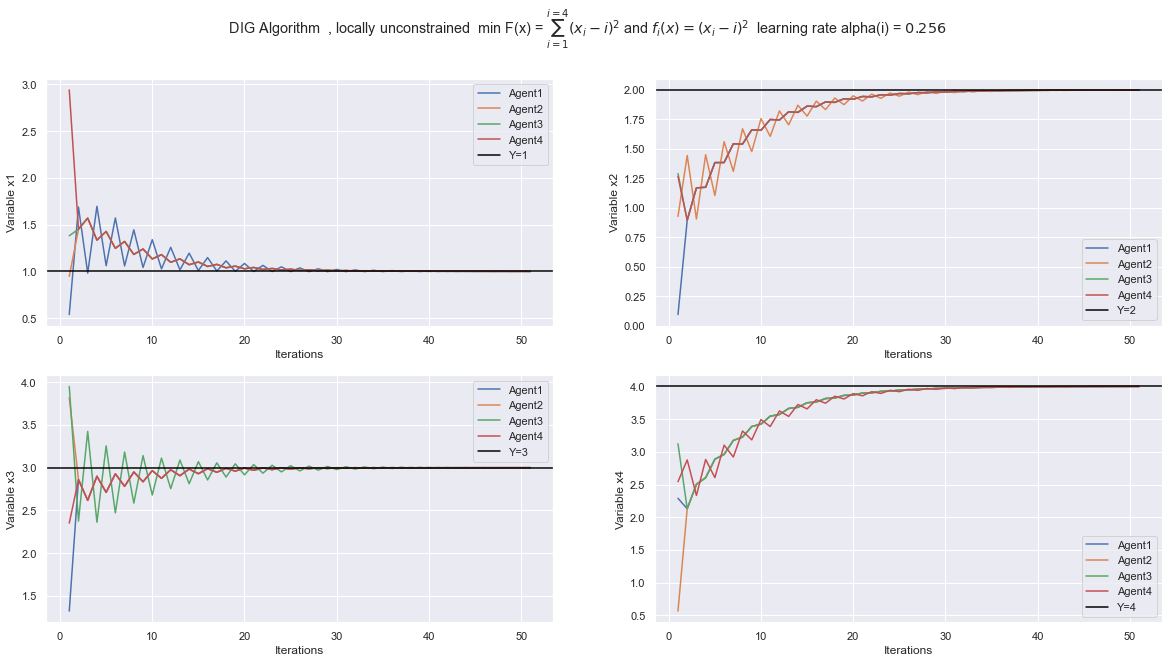

In [155]:
W = np.array([[1/4, 1/4, 1/4, 1/4], [1/4, 1/4, 1/4, 1/4],
    [1/4, 1/4, 1/4, 1/4], [1/4, 1/4, 1/4, 1/4]])
X= np.random.rand(4,4)*4
sol = np.array([1,2,3,4],dtype= float)
values_dig= DIG(W,X,50,subgradient_2,0.256)

print_plot(values_dig,title = ' DIG Algorithm  , locally unconstrained  min F(x) = $\sum_{i=1}^{i=4}{(x_i-i)^2}$ and $f_i(x) = (x_i-i)^2$  learning rate alpha(i) = $ 0.256$ ')